This is Will's edit of a notebook originally written by Javier.

# Correlations between H II region parameters

We look at correlations between 6 principal measurements that fall into two groups: 

* Basic parameters: 
    * Size: $S$
    * Ionizing luminosity: $L(\mathrm{H\alpha})$
    * Distance: $d$
    * Velocity dispersion on line of sigth: $\sigma_{\text{los}}$
* Velocity structure function parameters:
    * Velocity dispersion on plane of sky: $\sigma_{\text{pos}}$
    * Velocity autocorrelation length scale: $r_0$
    * Structure function slope in inertial range: $m$


In [1]:
import time
start_time=time.time()
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import lmfit
import statsmodels.api as sm
import linmix
from scipy.stats import pearsonr
import pickle
import math


Basic parameter table

In [2]:
Region =["NGC 604","NGC 595","Hubble X","Hubble V","30Dor" ,"Carina","NGC 346","M8"   ,"OrionL","OrionS"]

LHa    =[2.63e39  ,8.91e38  ,1.62e38   ,1.99e38   ,2.93e39 ,3.5e38  ,6e38     ,3e37   ,1.51e37 ,1.51e37 ]
LHaer  =[2.63e38  ,8.91e37  ,1.62e37   ,1.99e37   ,2.93e38 ,3.58e37 ,6e37     ,3e36   ,1.51e36 ,1.51e36 ]

Diam   =[400      ,400      ,160       ,130       ,370     ,200     ,220      ,25     ,5       ,5       ]
Diamer =[40       ,40       ,16        ,13        ,37      ,20      ,22       ,2.5    ,0.5     ,0.5     ]

Dist   =[840      ,840      ,500       ,500       ,50      ,2.35    ,61.7     ,1.25   ,0.4     ,0.4     ]
Dister =[30       ,30       ,40        ,40        ,0.19    ,0.05    ,1.1      ,0.1    ,0.02    ,0.02    ]

siglos =[16.21   ,18.33    ,12.3      ,13.4      ,31.7    ,22.46   ,10.1     ,13.6   ,6       ,6       ]
sigloser=[7.7     ,5.7      ,1.23      ,1.34      ,3.17    ,2.7     ,1.01     ,0.8    ,1       ,1       ]

#sigW   =[23.1     ,27.1     ,13.4      ,14.7      ,31.7    ,22.46   ,10.2     ,13.6   ,6       ,6       ]
SFR    =[5.3e-3   ,2.6e-3   ,3.1e-4    ,1.5e-4    ,1.3e-2  ,1.0e-2  ,0.0021   ,1.0e-4 ,5.3e-5  ,5.3e-5  ]
n      =[3        ,4        ,5         ,8         ,250     ,500     ,100      ,60     ,150     ,4000    ] 

Load results

In [3]:
samples=pd.read_csv('Results//file-names2.csv',header=None)

CI = {}

for i in range(len(samples)):
    pickle_in = open('Results//CI' + samples[0][i] + '.pkl',"rb")
    df = pickle.load(pickle_in)
    CI[samples[0][i]] = df

SF = {}

for i in range(len(samples)):
    pickle_in = open('Results//SF' + samples[0][i] + '.pkl',"rb")
    df = pickle.load(pickle_in)
    SF[samples[0][i]] = df

In [4]:
samples

,0
0,N604H
1,N595
2,HX
3,HV
4,Dor
5,CarC
6,N346
7,M8
8,OrionS


## Results to table

Create the columns for the values

In [5]:
#sigma
sig = [[0]*(1) for i in range(len(samples))]
siger = [[0]*(1) for i in range(len(samples))]
#velocity dispersion with 2-sig intervals
sig2 = [[0]*(1) for i in range(len(samples))]
sig2er = [[0]*(1) for i in range(len(samples))]
sig2s2 = [[0]*(1) for i in range(len(samples))]
sig2s2p = [[0]*(1) for i in range(len(samples))]
sig2s2m = [[0]*(1) for i in range(len(samples))]
#correlation length with 2-sig intervals
r0 = [[0]*(1) for i in range(len(samples))]
r0er = [[0]*(1) for i in range(len(samples))]
r0s2 = [[0]*(1) for i in range(len(samples))]
r0s2p = [[0]*(1) for i in range(len(samples))]
r0s2m = [[0]*(1) for i in range(len(samples))]
#power-law
m = [[0]*(1) for i in range(len(samples))]
mer = [[0]*(1) for i in range(len(samples))]
ms2 = [[0]*(1) for i in range(len(samples))]
ms2p = [[0]*(1) for i in range(len(samples))]
ms2m = [[0]*(1) for i in range(len(samples))]
#noise with 2-sig intervals
n = [[0]*(1) for i in range(len(samples))]
ner = [[0]*(1) for i in range(len(samples))]
b0s2 = [[0]*(1) for i in range(len(samples))]
b0s2p = [[0]*(1) for i in range(len(samples))]
b0s2m = [[0]*(1) for i in range(len(samples))]
#seeing with 2-sig intervals
s0 = [[0]*(1) for i in range(len(samples))]
s0er = [[0]*(1) for i in range(len(samples))]
s0s2 = [[0]*(1) for i in range(len(samples))]
s0s2p = [[0]*(1) for i in range(len(samples))]
s0s2m = [[0]*(1) for i in range(len(samples))]
#box sizes 2-sig intervals
box_sizes = [[0]*(1) for i in range(len(samples))]
box_sizes_int = [[0]*(1) for i in range(len(samples))]
box_sizeser = [[0]*(1) for i in range(len(samples))]
deltabox = [[0]*(1) for i in range(len(samples))]
boxr0ratio = [[0]*(1) for i in range(len(samples))]
boxr0ratio_int = [[0]*(1) for i in range(len(samples))]

pc = [[0]*(1) for i in range(len(samples))]


Create 2-sigma confidence intervals

In [6]:
for i in range(len(samples)):
    sig2s2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['sig2'],[2.5, 97.5])
    r0s2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['r0'],[2.5, 97.5])
    ms2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['m'],[2.5, 97.5])
    s0s2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['s0'],[2.5, 97.5])
    b0s2[i] = np.percentile(CI[samples[0][i]]['result_emcee'].flatchain['noise'],[2.5, 97.5])

Results to empty columns

LM

In [7]:
for i in range(len(samples)):    
#for i in [0,2,4,5,6,9]:
    sig[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].value,3)**0.5
    siger[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].stderr,3)**0.5
    
    sig2[i] = int(np.round(CI[samples[0][i]]['result'].params['sig2'].value,2))
    sig2er[i] = int(np.round(CI[samples[0][i]]['result'].params['sig2'].stderr,2))
    sig2s2p[i] = np.round(sig2s2[i][1]-CI[samples[0][i]]['result'].params['sig2'].value,4)
    sig2s2m[i] = np.round(CI[samples[0][i]]['result'].params['sig2'].value-sig2s2[i][0],4)
    
    r0[i] = np.round(CI[samples[0][i]]['result'].params['r0'].value,3)
    r0er[i] = np.round(CI[samples[0][i]]['result'].params['r0'].stderr,3)
    r0s2p[i] = np.round(r0s2[i][1]-CI[samples[0][i]]['result'].params['r0'].value,4)
    r0s2m[i] = np.round(CI[samples[0][i]]['result'].params['r0'].value-r0s2[i][0],4)
    
    m[i] = np.round(CI[samples[0][i]]['result'].params['m'].value,2)
    mer[i] = np.round(CI[samples[0][i]]['result'].params['m'].stderr,1)
    ms2p[i] = np.round(ms2[i][1]-CI[samples[0][i]]['result'].params['m'].value,4)
    ms2m[i] = np.round(CI[samples[0][i]]['result'].params['m'].value-ms2[i][0],4)
    
    n[i] = np.round(CI[samples[0][i]]['result'].params['noise'].value,2)
    ner[i] = np.round(CI[samples[0][i]]['result'].params['noise'].stderr,2)
    b0s2p[i] = np.round(b0s2[i][1]-CI[samples[0][i]]['result'].params['noise'].value,4)
    b0s2m[i] = np.round(CI[samples[0][i]]['result'].params['noise'].value-b0s2[i][0],4)
    
    s0[i] = np.round(CI[samples[0][i]]['result'].params['s0'].value,3)
    s0er[i] = np.round(CI[samples[0][i]]['result'].params['s0'].stderr,3)
    s0s2p[i] = np.round(s0s2[i][1]-CI[samples[0][i]]['result'].params['s0'].value,4)
    s0s2m[i] = np.round(CI[samples[0][i]]['result'].params['s0'].value-s0s2[i][0],4)
    
    box_sizes[i] = np.round(CI[samples[0][i]]['box_size'],2)
    deltabox[i] =  CI[samples[0][i]]['r'].max()-CI[samples[0][i]]['box_size']
    pc[i] = SF[samples[0][i]]['pc']
    boxr0ratio[i] = box_sizes[i]/r0[i]

In [8]:
#pc[8]=pc[8]/60

In [9]:
for i in range(len(samples)):
     box_sizes_int[i] = int(np.round(CI[samples[0][i]]['box_size'],2))
     boxr0ratio_int[i] = int(np.rint(box_sizes[i]/r0[i]))

Crate table with standar errors

In [10]:
td = pd.DataFrame(
    {
       "A": sig2,
       "DA": sig2er,
       "B": m,
       "DB": mer,
       "C": r0,
       "DC": r0er,
       "E": n,
       "DE": ner,
       "F": s0,
       "DF": s0er,
        "G":  box_sizes_int,
        "H": boxr0ratio_int,
        "I": np.round((np.array(s0)*2.35)/np.array(pc),1),
        "DI": np.round((np.array(s0er)*2.35)/np.array(pc),1),
    },
)

In [11]:
td=td.sort_values( by='A', ascending=False)

In [12]:
tdx=(td.groupby(td.columns.str[-1], axis=1).apply(lambda x: x.astype(str).apply('$\pm$'.join, 1)))
SFres=tdx[['A','E','F','C','G','B','H','I']].copy()

In [13]:
SFres.rename(columns={'A':'$\sigma^2$ [km$^2$/s$^2$]','E':'$B_{noise}$ [km$^2$/s$^2$]','B':'$m$','C':'$r_0$ [pc]','F':'$s0$ (rms) [pc]','G':'L$_{box}$ [pc]','H':'L$_{box} / r_0$','I':'$s0$ (FMHW) [arcsec]'}, inplace=True)
SFres.insert(loc=0, column='Region', value=samples)
SFres

,Region,$\sigma^2$ [km$^2$/s$^2$],$B_{noise}$ [km$^2$/s$^2$],$s0$ (rms) [pc],$r_0$ [pc],L$_{box}$ [pc],$m$,L$_{box} / r_0$,$s0$ (FMHW) [arcsec]
4,Dor,297$\pm$13,6.16$\pm$0.8,0.158$\pm$0.031,3.858$\pm$0.331,31,0.85$\pm$0.1,8,1.5$\pm$0.3
0,N604H,82$\pm$18,0.35$\pm$0.46,2.013$\pm$1.219,11.402$\pm$2.352,173,0.81$\pm$0.3,15,1.2$\pm$0.7
1,N595,53$\pm$3,1.66$\pm$1.8,0.407$\pm$0.738,11.239$\pm$0.45,196,1.38$\pm$0.1,17,0.2$\pm$0.4
6,N346,35$\pm$0,1.2$\pm$0.35,0.058$\pm$0.015,1.782$\pm$0.093,20,0.8$\pm$0.0,11,0.5$\pm$0.1
5,CarC,18$\pm$14,2.26$\pm$49.85,0.007$\pm$1.192,0.55$\pm$0.274,19,1.16$\pm$0.7,36,1.6$\pm$271.3
2,HX,15$\pm$1,0.35$\pm$0.47,0.449$\pm$0.259,4.133$\pm$0.399,78,0.94$\pm$0.1,19,0.4$\pm$0.3
8,OrionS,12$\pm$0,0.03$\pm$0.0,0.002$\pm$0.0,0.068$\pm$0.002,0,1.07$\pm$0.0,7,2.4$\pm$0.0
3,HV,10$\pm$0,0.11$\pm$0.1,0.485$\pm$0.108,3.662$\pm$0.316,61,0.7$\pm$0.1,17,0.5$\pm$0.1
7,M8,7$\pm$3,0.44$\pm$4.1,0.007$\pm$0.724,1.035$\pm$0.109,16,1.26$\pm$0.2,16,2.7$\pm$280.8


Crate table with confidence intervals

In [14]:
s0f = pd.DataFrame(
    {
        "s0 [rms]":s0,
       "- [rms]": s0s2m,
       "+ [rms]": s0s2p,
       "s0 [FWHM]": np.array(s0)*2.35/np.array(pc),
       "- [FWHM]": np.array(s0s2m)*2.35/np.array(pc),
       "+ [FWHM]": np.array(s0s2p)*2.35/np.array(pc),
        "b0 ":n,
       "- ": b0s2m,
       "+": b0s2p,
    }
)

s0f.insert(loc=0, column='Region', value=samples)


s0f

,Region,s0 [rms],- [rms],+ [rms],s0 [FWHM],- [FWHM],+ [FWHM],b0,-,+
0,N604H,2.013,0.8235,1.1675,1.161602,0.475201,0.673706,0.35,0.3248,1.0242
1,N595,0.407,-0.0052,0.6174,0.234859,-0.003001,0.356271,1.66,1.0864,1.7353
2,HX,0.449,0.1969,0.1953,0.435281,0.190884,0.189333,0.35,0.2949,1.4048
3,HV,0.485,0.1624,0.2475,0.470181,0.157438,0.239938,0.11,0.1094,0.2624
4,Dor,0.158,0.0468,0.1024,1.531722,0.453700,0.992711,6.16,1.6738,1.7206
5,CarC,0.007,0.0061,0.0077,1.592984,1.388172,1.752282,2.26,1.9754,2.4217
6,N346,0.058,0.0246,0.0315,0.453450,0.192325,0.246270,1.20,0.8144,0.5589
7,M8,0.007,0.0062,0.0019,2.714445,2.404223,0.736778,0.44,0.3049,0.2099
8,OrionS,0.002,0.0002,0.0003,2.364499,0.236450,0.354675,0.03,0.0050,0.0050


In [15]:
s1f = pd.DataFrame(
    {
        "sig2":sig2,
       "- ": sig2s2m,
       "+ ": sig2s2p,
        "r0 ":r0,
       " - ": r0s2m,
       " +": r0s2p,
        "m ":m,
       "  -": ms2m,
       "  +": ms2p,
    }
)

s1f.insert(loc=0, column='Region', value=samples)


s1f

,Region,sig2,-,+,r0,-,+,m,-,+
0,N604H,82,11.1712,23.5696,11.402,4.0619,6.2649,0.81,0.2683,0.2251
1,N595,53,1.9116,4.5893,11.239,0.8449,0.7460,1.38,0.1493,0.0902
2,HX,15,1.6914,-0.0186,4.133,0.6766,0.7476,0.94,0.0425,0.2984
3,HV,10,1.0398,1.9200,3.662,0.6684,0.8004,0.70,0.1753,0.1403
4,Dor,297,19.6228,46.7137,3.858,0.4941,1.2923,0.85,0.1621,0.0805
5,CarC,18,1.5227,1.3939,0.550,0.0665,0.0815,1.16,0.1739,0.2769
6,N346,35,1.5104,2.4547,1.782,0.1527,0.2538,0.80,0.0760,0.0503
7,M8,7,0.7462,1.2286,1.035,0.1231,0.2332,1.26,0.1927,0.1765
8,OrionS,12,0.5288,0.7382,0.068,0.0042,0.0061,1.07,0.0385,0.0307


[None, Text(0, 0.5, 'r [pc]'), None, Text(0.5, 0, 'B(r) [km$^{2}$/s$^{2}$]')]

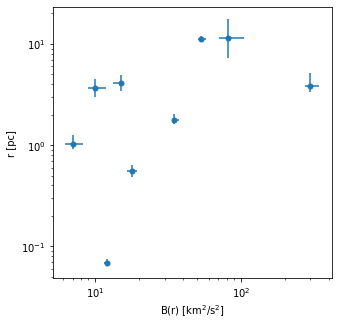

In [16]:
errorsig2 = [s1f['- '],s1f['+ ']]
errorr0 = [s1f[' - '],s1f[' +']]

fig, ax = plt.subplots(figsize=(5, 5))

ax.errorbar(s1f.sig2,s1f['r0 '], xerr = errorsig2, yerr = errorr0,  marker='o', linestyle=' ', markersize='5')
ax.set(
    xscale="log",
    yscale="log",
    ylabel="r [pc]",
    xlabel=r"B(r) [km$^{2}$/s$^{2}$]",
)

In [17]:
#SFres.to_latex('latex/sf-results.tex', escape=False, caption='Main results.',index=False)

In [18]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.202024221420288 seconds ---
